In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [ ]:
!pip install pymysql
import sqlalchemy
from sqlalchemy.sql import text
from urllib.parse import quote_plus

engine = sqlalchemy.create_engine("mysql+pymysql://root:%s@34.141.168.80/growrain" % quote_plus("Jinsha@15535!"))
query1 = '''SELECT Latitude, Longitude, Time, SoilMoisture, Percipitation from PredictRain;'''
with engine.connect().execution_options(autocommit=True) as con:
    rs1 = con.execute(text(query1))

raw_df = pd.DataFrame(rs1.fetchall())
raw_df = raw_df.reset_index()
raw_df = raw_df.drop('index', axis=1)
raw_df = raw_df.rename(columns={0:'Latitude',1:'Longitude',2:'Time',3:'SoilMoisture',4:'Percipitation'})

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 950.9 kB/s eta 0:00:00


<ipython-input-2-b840f56ff267>:9: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  rs1 = con.execute(text(query1))


In [ ]:
raw_df

,Latitude,Longitude,Time,SoilMoisture,Percipitation
0,0.000,0.000,2017-09-05 09:00:00,0.000000,0.03
1,0.000,0.000,2017-09-05 10:00:00,0.141852,0.02
2,0.000,0.000,2017-09-05 11:00:00,0.283214,0.02
3,0.000,0.000,2017-09-05 12:00:00,0.217857,0.02
4,0.000,0.000,2017-09-05 13:00:00,0.263571,0.02
...,...,...,...,...,...
750569,56.752,-3.542,2019-07-05 13:00:00,0.000000,0.49
750570,56.752,-3.542,2019-07-05 14:00:00,0.000000,0.27
750571,56.752,-3.542,2019-07-05 15:00:00,0.000000,0.19
750572,56.752,-3.542,2019-07-05 16:00:00,0.000000,0.14


In [ ]:
def setLocation(Lat,Lon):
   df =  raw_df[(raw_df['Latitude'] == Lat) & (raw_df['Longitude'] == Lon)]
   df =  df.drop('Latitude', axis=1)
   df =  df.drop('Longitude', axis=1)
   df.index = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
   return df

In [ ]:
df = setLocation(56.457,-2.976)
rain = df[['Percipitation','SoilMoisture']]      #.apply(lambda x: x*100)
rain

,Percipitation,SoilMoisture
Time,,
2018-05-30 20:00:00,0.00,26.425000
2018-05-30 21:00:00,0.01,26.590000
2018-05-30 22:00:00,0.01,26.727500
2018-05-30 23:00:00,0.01,26.489999
2018-05-31 00:00:00,0.03,26.582500
...,...,...
2019-06-08 07:00:00,0.24,35.042500
2019-06-08 08:00:00,0.21,35.015000
2019-06-08 09:00:00,0.26,34.957500


In [ ]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a[1]] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
X1, y1 = df_to_X_y2(rain)
X1.shape, y1.shape

((2314, 6, 1), (2314,))

In [ ]:
n1 = round((X1.shape[0]*70)/100)
n2 = n1 + round((X1.shape[0]*20)/100)

X_train1, y_train1 = X1[:n1], y1[:n1]
X_val1, y_val1 = X1[n1:n2], y1[n1:n2]
X_test1, y_test1 = X1[n2:], y1[n2:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1620, 6, 1), (1620,), (463, 6, 1), (463,), (231, 6, 1), (231,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import History
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((6, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(), 'accuracy'])

In [ ]:
history = model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp1])

Epoch 1/50
47/51 [==========================>...] - ETA: 0s - loss: 0.1158 - root_mean_squared_error: 0.3403 - accuracy: 0.2473

51/51 [==============================] - 9s 108ms/step - loss: 0.1127 - root_mean_squared_error: 0.3357 - accuracy: 0.2519 - val_loss: 0.0643 - val_root_mean_squared_error: 0.2536 - val_accuracy: 0.5119
Epoch 2/50
51/51 [==============================] - 0s 8ms/step - loss: 0.1086 - root_mean_squared_error: 0.3295 - accuracy: 0.2519 - val_loss: 0.0656 - val_root_mean_squared_error: 0.2561 - val_accuracy: 0.5119
Epoch 3/50
51/51 [==============================] - 1s 10ms/step - loss: 0.1083 - root_mean_squared_error: 0.3290 - accuracy: 0.2519 - val_loss: 0.0648 - val_root_mean_squared_error: 0.2545 - val_accuracy: 0.5119
Epoch 4/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1080 - root_mean_squared_error: 0.3287 - accuracy: 0.2519 - val_loss: 0.0649 - val_root_mean_squared_error: 0.2548 - val_accuracy: 0.5119
Epoch 5/50
49/51 [===========================>..] - ETA: 0s - loss: 0.1071 - root_mean_squared_error: 0.3273 - accuracy: 0.2506

51/51 [==============================] - 6s 128ms/step - loss: 0.1077 - root_mean_squared_error: 0.3282 - accuracy: 0.2519 - val_loss: 0.0640 - val_root_mean_squared_error: 0.2530 - val_accuracy: 0.5119
Epoch 6/50
51/51 [==============================] - 0s 10ms/step - loss: 0.1076 - root_mean_squared_error: 0.3281 - accuracy: 0.2519 - val_loss: 0.0643 - val_root_mean_squared_error: 0.2535 - val_accuracy: 0.5119
Epoch 7/50
46/51 [==========================>...] - ETA: 0s - loss: 0.1138 - root_mean_squared_error: 0.3373 - accuracy: 0.2548

51/51 [==============================] - 5s 98ms/step - loss: 0.1076 - root_mean_squared_error: 0.3280 - accuracy: 0.2519 - val_loss: 0.0638 - val_root_mean_squared_error: 0.2525 - val_accuracy: 0.5119
Epoch 8/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1076 - root_mean_squared_error: 0.3281 - accuracy: 0.2519 - val_loss: 0.0653 - val_root_mean_squared_error: 0.2555 - val_accuracy: 0.5119
Epoch 9/50
51/51 [==============================] - 0s 10ms/step - loss: 0.1077 - root_mean_squared_error: 0.3281 - accuracy: 0.2519 - val_loss: 0.0641 - val_root_mean_squared_error: 0.2531 - val_accuracy: 0.5119
Epoch 10/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1075 - root_mean_squared_error: 0.3278 - accuracy: 0.2519 - val_loss: 0.0646 - val_root_mean_squared_error: 0.2541 - val_accuracy: 0.5119
Epoch 11/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1076 - root_mean_squared_error: 0.3280 - accuracy: 0.2519 - val_loss: 0.0640 - val_ro

51/51 [==============================] - 6s 123ms/step - loss: 0.1075 - root_mean_squared_error: 0.3279 - accuracy: 0.2519 - val_loss: 0.0634 - val_root_mean_squared_error: 0.2518 - val_accuracy: 0.5119
Epoch 14/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1075 - root_mean_squared_error: 0.3278 - accuracy: 0.2519 - val_loss: 0.0636 - val_root_mean_squared_error: 0.2522 - val_accuracy: 0.5119
Epoch 15/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1077 - root_mean_squared_error: 0.3281 - accuracy: 0.2519 - val_loss: 0.0640 - val_root_mean_squared_error: 0.2529 - val_accuracy: 0.5119
Epoch 16/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1073 - root_mean_squared_error: 0.3276 - accuracy: 0.2519 - val_loss: 0.0642 - val_root_mean_squared_error: 0.2534 - val_accuracy: 0.5119
Epoch 17/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1073 - root_mean_squared_error: 0.3275 - accuracy: 0.2519 - val_loss: 0.0646 - val_

51/51 [==============================] - 5s 99ms/step - loss: 0.1072 - root_mean_squared_error: 0.3274 - accuracy: 0.2519 - val_loss: 0.0632 - val_root_mean_squared_error: 0.2515 - val_accuracy: 0.5119
Epoch 21/50
51/51 [==============================] - 1s 13ms/step - loss: 0.1073 - root_mean_squared_error: 0.3275 - accuracy: 0.2519 - val_loss: 0.0635 - val_root_mean_squared_error: 0.2519 - val_accuracy: 0.5119
Epoch 22/50
51/51 [==============================] - 1s 14ms/step - loss: 0.1074 - root_mean_squared_error: 0.3277 - accuracy: 0.2519 - val_loss: 0.0635 - val_root_mean_squared_error: 0.2521 - val_accuracy: 0.5119
Epoch 23/50
51/51 [==============================] - 1s 15ms/step - loss: 0.1072 - root_mean_squared_error: 0.3274 - accuracy: 0.2519 - val_loss: 0.0642 - val_root_mean_squared_error: 0.2534 - val_accuracy: 0.5119
Epoch 24/50
51/51 [==============================] - 1s 13ms/step - loss: 0.1071 - root_mean_squared_error: 0.3273 - accuracy: 0.2519 - val_loss: 0.0637 - v

51/51 [==============================] - 6s 111ms/step - loss: 0.1073 - root_mean_squared_error: 0.3275 - accuracy: 0.2519 - val_loss: 0.0632 - val_root_mean_squared_error: 0.2514 - val_accuracy: 0.5119
Epoch 29/50
51/51 [==============================] - 1s 10ms/step - loss: 0.1072 - root_mean_squared_error: 0.3274 - accuracy: 0.2519 - val_loss: 0.0636 - val_root_mean_squared_error: 0.2521 - val_accuracy: 0.5119
Epoch 30/50
51/51 [==============================] - 1s 10ms/step - loss: 0.1073 - root_mean_squared_error: 0.3275 - accuracy: 0.2519 - val_loss: 0.0635 - val_root_mean_squared_error: 0.2520 - val_accuracy: 0.5119
Epoch 31/50
51/51 [==============================] - 0s 10ms/step - loss: 0.1071 - root_mean_squared_error: 0.3272 - accuracy: 0.2519 - val_loss: 0.0641 - val_root_mean_squared_error: 0.2532 - val_accuracy: 0.5119
Epoch 32/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1069 - root_mean_squared_error: 0.3270 - accuracy: 0.2519 - val_loss: 0.0637 - v

51/51 [==============================] - 6s 111ms/step - loss: 0.1065 - root_mean_squared_error: 0.3264 - accuracy: 0.2519 - val_loss: 0.0630 - val_root_mean_squared_error: 0.2510 - val_accuracy: 0.5119


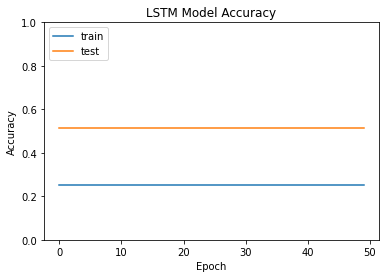

In [ ]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.set_ylim([0,1])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

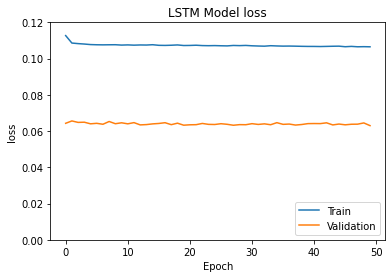

In [ ]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.set_ylim([0,0.12])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

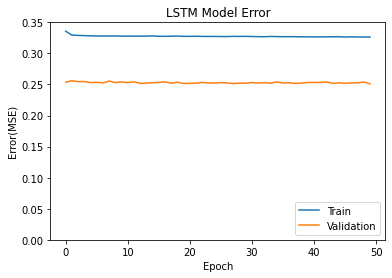

In [ ]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.set_ylim([0,0.35])
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('LSTM Model Error')
plt.ylabel('Error(MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [ ]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

51/51 [==============================] - 1s 3ms/step


,Train Predictions,Actuals
0,0.078861,0.09
1,0.079492,0.14
2,0.079481,0.16
3,0.078673,0.15
4,0.079110,0.14
...,...,...
1615,0.142559,0.00
1616,0.145447,0.00
1617,0.148207,0.00
1618,0.150673,0.00


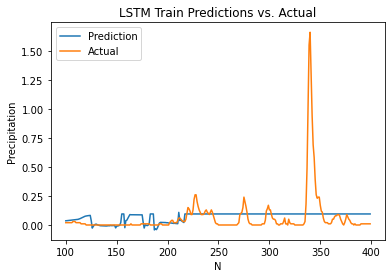

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][100:400])
plt.plot(train_results['Actuals'][100:400])
plt.title('LSTM Train Predictions vs. Actual')
plt.ylabel('Precipitation')
plt.xlabel('N')
plt.legend(['Prediction', 'Actual'], loc='upper left')

In [ ]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

15/15 [==============================] - 0s 5ms/step


,Val Predictions,Actuals
0,0.154349,0.02
1,0.156312,0.06
2,0.157651,0.07
3,0.158512,0.09
4,0.158620,0.09
...,...,...
458,0.058702,0.00
459,0.058788,0.00
460,0.061237,0.01
461,0.080196,0.00


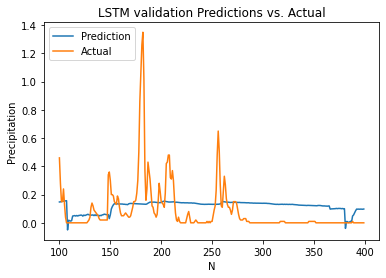

In [ ]:
plt.plot(val_results['Val Predictions'][100:400])
plt.plot(val_results['Actuals'][100:400])
plt.title('LSTM validation Predictions vs. Actual')
plt.ylabel('Precipitation')
plt.xlabel('N')
plt.legend(['Prediction', 'Actual'], loc='upper left')

In [ ]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

8/8 [==============================] - 0s 4ms/step


,Test Predictions,Actuals
0,0.084620,0.00
1,0.083993,0.00
2,0.083601,0.00
3,0.083813,0.00
4,0.083840,0.00
...,...,...
226,0.126109,0.24
227,0.125904,0.21
228,0.125738,0.26
229,0.125390,0.32


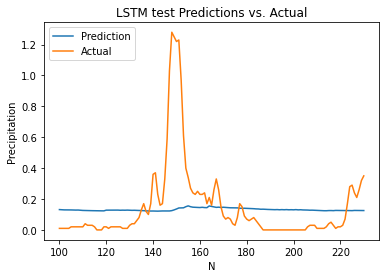

In [ ]:
plt.plot(test_results['Test Predictions'][100:400])
plt.plot(test_results['Actuals'][100:400])
plt.title('LSTM test Predictions vs. Actual')
plt.ylabel('Precipitation')
plt.xlabel('N')
plt.legend(['Prediction', 'Actual'], loc='upper left')